In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
from itertools import compress, combinations
import os

In [6]:
# Inspect data
figdir = r'/home/andy/Documents/class/cse/cse546/CSE-546-HW-3/figs'
poly_log_K1_B300_N30 = np.loadtxt(os.path.join(figdir, 'poly_log_K1_B300_N30.txt'))
poly_log_K10_B300_N300 = np.loadtxt(os.path.join(figdir, 'poly_log_K10_B300_N300.txt'))
rbf_log_K1_B300_N30 = np.loadtxt(os.path.join(figdir, 'rbf_log_K1_B300_N30.txt'))
rbf_log_K10_B300_N300 = np.loadtxt(os.path.join(figdir, 'rbf_log_K10_B300_N300.txt'))

In [9]:
poly_log_K1_B300_N30[np.argmin(poly_log_K1_B300_N30[:,2])]

array([4.73684211, 0.46415888, 4.12419501])

In [10]:
poly_log_K10_B300_N300[np.argmin(poly_log_K10_B300_N300[:,2])]

array([15.78947368,  0.1       ,  4.79954416])

In [11]:
rbf_log_K1_B300_N30[np.argmin(rbf_log_K1_B300_N30[:,2])]

array([30.        ,  0.1       ,  2.23215106])

In [15]:
rbf_log_K10_B300_N300[np.argmin(rbf_log_K10_B300_N300[:,2])]

array([3.15789474e+01, 1.00000000e-03, 1.09493178e+00])

In [17]:
def f(x):
    return 4*np.sin(np.pi*x)*np.cos(6*np.pi*x**2)

In [18]:
def k_poly(x, z, d):
    '''
    x, z in R^n; d in R
    '''
    return np.power(1+ x*z, d)

def k_rbf(x, z, gamma):
    '''
    x, z in R^n; gamma in R
    '''
    return np.exp(-gamma*np.square(x-z))

In [19]:
def kernel_ridge_regression_1d(x, y, kernel, k_params, regularization):
    '''
    Find alpha_hat analytically. Return function that computes sum over all alpha-weighted 
    kernel data vectors for each new x (each x_p in possible many x_predict).
    
    @requires x_predict is an iterable of x_p data
    '''
    xi, xj = np.meshgrid(x,x)
    K = kernel(xi,xj,k_params)
    alpha_hat,_,_,_ = np.linalg.lstsq(K.T@K+regularization*K, K.T@y, rcond=None) # Solve, but not nec. full-rank
    return lambda x_predict: np.array([np.sum(alpha_hat*kernel(x, x_p, k_params)) for x_p in x_predict])

In [20]:
def k_fold_cv(k, x, y, kernel, k_params, regularization):
    '''
    Returns the average error of the k-fold cross validation.
    @requires len(x)/k in integers (creates len(x)/k folds)
    '''
    n = len(x)
    indices = np.arange(n).astype(int)
    k_folds = np.random.permutation(indices).reshape(int(n/k), k) # Each row is a k-fold. 
    k_error = np.zeros(int(n/k))
    for i, k_validation in enumerate(k_folds):
        k_train = np.ones(n).astype(int)
        k_train[k_validation] = 0
        x_train = np.array([xi for xi in compress(x, k_train)])
        y_train = np.array([yi for yi in compress(y, k_train)])
        f_hat_k = kernel_ridge_regression_1d(x_train, y_train, kernel, k_params, regularization)
        k_error[i] = np.sum(np.power(y[k_validation]-f_hat_k(x[k_validation]), 2))/len(k_validation)
    return np.mean(k_error)

In [27]:
N = 300
np.random.seed(1)
x = np.random.rand(N)
y = f(x) + np.random.randn(N)

K = 10 ## for k-fold valuation

In [28]:
1/np.median([(i[0]-i[1])**2 for i in combinations(x,2)]) # Use the heuristic instead

10.822572420950236

I am very confused on the replacement issue: I clearly cannot replace the data because I'll get linear dependence but I'm not sure there is any reweight possible on a multi-draw because I'll be adjusting my coefficients to get the best fit. Turns out, you can use the linalg lstsq instead!

In [246]:
%%time
search_reg = np.power(10., np.linspace(-3,3,10))
search_d = np.linspace(0,N,20)

search_poly = np.zeros([len(search_reg)*len(search_d),3])
index = 0
for d_i in search_d:
    for reg_i in search_reg: 
        search_poly[index] = np.array([d_i, reg_i, k_fold_cv(K, x, y, k_poly, d_i, reg_i)])
        index = index + 1

print(search_poly[np.argmin(search_poly[:,2])])

KeyboardInterrupt: 

In [247]:
x_real = np.linspace(0,1,100)
d,reg,_ = search_poly[np.argmin(search_poly[:,2])]
f_hat_poly = kernel_ridge_regression_1d(x, y, k_poly, d, reg)

B = 300
indices = np.arange(N).astype(int)
f_hats = []
for i in range(B):
    bootstrap = np.random.choice(indices, N, replace=True)
    f_hats.append(kernel_ridge_regression_1d(x[bootstrap], y[bootstrap], k_poly, d, reg))

# Form bootstrap confidence intervals using percentiles at each x
low, high = np.sort(np.array([f_hat(x_real) for f_hat in f_hats]), axis=0)[[int(0.025*B), int(0.975*B)],:]
    
plt.grid(True)
plt.plot(x_real, f(x_real), lw=4)
plt.plot(x_real, f_hat_poly(x_real), c='darkred', lw=4)
plt.fill_between(x_real, low, high, color='red', alpha=0.5)
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(r'/home/andy/Documents/class/cse/cse546/CSE-546-HW-3/figs/kpoly_K_{}_B{}_N{}.pdf'.format(K,B,N))

KeyboardInterrupt: 

In [ ]:
%%time
search_reg = np.power(10., np.linspace(-3,3,10))
search_gamma = np.linspace(0,N,20)

search_rbf = np.zeros([len(search_reg)*len(search_gamma),3])
index = 0
for g_i in search_gamma:
    for reg_i in search_reg: 
        search_rbf[index] = np.array([g_i, reg_i, k_fold_cv(K, x, y, k_rbf, g_i, reg_i)])
        index = index + 1
        
print(search_rbf[np.argmin(search_rbf[:,2])])

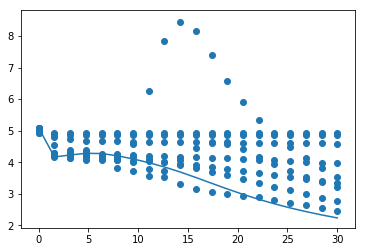

In [235]:
plt.plot(search_rbf[search_rbf[:,1]==.1,0], search_rbf[search_rbf[:,1]==.1,2])
plt.scatter(search_rbf[search_rbf[:,1]!=.1,0], search_rbf[search_rbf[:,1]!=.1,2])

In [ ]:
x_real = np.linspace(0,1,250)
gamma,reg,_ = search_rbf[np.argmin(search_rbf[:,2])]
gamma = 1/np.median([(i[0]-i[1])**2 for i in combinations(x,2)]) # Use the heuristic instead
f_hat_rbf = kernel_ridge_regression_1d(x, y, k_rbf, gamma, reg)

B = 300
indices = np.arange(N).astype(int)
f_hats = []
for i in range(B):
    bootstrap = np.unique(np.random.choice(indices, N, replace=True))
    f_hats.append(kernel_ridge_regression_1d(x[bootstrap], y[bootstrap], k_rbf, gamma, reg))

# Form bootstrap confidence intervals using percentiles at each x
low, high = np.sort(np.array([f_hat(x_real) for f_hat in f_hats]), axis=0)[[int(0.025*B), int(0.975*B)],:]
    
plt.grid(True)
plt.plot(x_real, f(x_real), lw=4)
plt.plot(x_real, f_hat_rbf(x_real), c='darkred', lw=4)
plt.fill_between(x_real, low, high, color='red', alpha=0.5)
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.savefig(r'/home/andy/Documents/class/cse/cse546/CSE-546-HW-3/figs/krbf_K{}_B{}_N{}.pdf'.format(K,B,N))